# Meta-Learning for ECG Anomaly Detection

This notebook demonstrates a meta-learning approach to automatically select the best anomaly detection model
for blocks of ECG time series. The process includes:

- Splitting ECG signals into blocks
- Extracting features with `tsfresh`
- Evaluating anomaly detection models (`KNN`, `IsolationForest`)
- Training a meta-classifier to choose the best-performing model

**Author**: Leonardo Falanga  MAT. [0522502019]
**Instructor**: Prof. Caruccio


## 1. Import Required Libraries
I import the necessary libraries for time series processing, feature extraction, anomaly detection, and evaluation.

In [1]:
import os
import pandas as pd
import numpy as np
from tsfresh import extract_features
from tsfresh.feature_extraction import EfficientFCParameters
from tsfresh.utilities.dataframe_functions import impute
from pyod.models.knn import KNN
from pyod.models.iforest import IForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns


## 2. Load ECG Data and Segment into Blocks
I load ECG signals from `.out` files and split them into fixed-size blocks for feature extraction.

In [2]:
data_folder = './ECG'
block_size = 2000
all_blocks = []
labels = []
id_counter = 0

ecg_files = [f for f in os.listdir(data_folder) if f.endswith('.out')]

for file in ecg_files:
    df = pd.read_csv(os.path.join(data_folder, file), header=None, names=['value', 'label'])
    n_blocks = len(df) // block_size
    for i in range(n_blocks):
        block = df.iloc[i*block_size:(i+1)*block_size].copy()
        block['id'] = id_counter
        block['timestamp'] = block.index
        block['true_label'] = block['label']
        labels.append(block['label'])
        all_blocks.append(block)
        id_counter += 1


## 3. Feature Extraction with TSFresh
I extract statistical and structural features from each ECG block using the TSFresh library.

In [3]:
df_all = pd.concat(all_blocks)
features_all = extract_features(
    df_all[['id', 'timestamp', 'value']],
    column_id='id',
    column_sort='timestamp',
    default_fc_parameters=EfficientFCParameters(),
    disable_progressbar=False,
    n_jobs=4
)
features_all = impute(features_all)


Feature Extraction: 100%|██████████| 20/20 [00:14<00:00,  1.36it/s]
/Users/leonardofalanga/miniconda3/lib/python3.12/site-packages/tsfresh/utilities/dataframe_functions.py:198: RuntimeWarning: The columns ['value__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


## 4. Evaluate KNN vs Isolation Forest
I compare two unsupervised anomaly detection models on each block and select the one with the highest accuracy.

In [4]:
meta_X = []
meta_y = []
models = {'iforest': IForest(), 'knn': KNN()}

for idx, block in enumerate(all_blocks):
    best_model = None
    best_accuracy = -1
    for name, model in models.items():
        model.fit(block[['value']])
        preds = model.labels_
        acc = accuracy_score(block['true_label'], preds)
        if acc > best_accuracy:
            best_accuracy = acc
            best_model = name
    meta_X.append(features_all.iloc[idx])
    meta_y.append(best_model)


## 5. Train the Meta-Model
I train a Random Forest classifier to learn which model (KNN or IForest) performs best based on extracted features.

In [5]:
X = pd.DataFrame(meta_X)
y = pd.Series(meta_y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Meta-model accuracy on test set:", accuracy_score(y_test, y_pred))


Meta-model accuracy on test set: 0.9080459770114943


## 6. Visualize Results
I show a confusion matrix of the meta-model's predictions on unseen data to evaluate its decision-making accuracy.

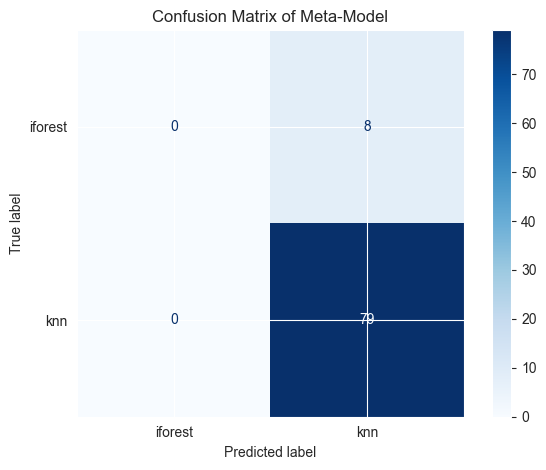

In [6]:
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, cmap='Blues')
plt.title("Confusion Matrix of Meta-Model")
plt.tight_layout()
plt.show()